<a href="https://colab.research.google.com/github/NH0917/signate_tree/blob/main/model12_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

・2015年の外部データを利用<br>
・problemsの細分化<br>
・tree_dbhのcleansing<br>
・カウントビニング

In [ ]:
!pip install optuna
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=2593257926e177224c0d72e4d3c694d31b394e3687922c1c9b3e88b6bbe9cf1b
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import seaborn as sns
import os
import warnings
import optuna
import seaborn as sns
import umap
warnings.filterwarnings("ignore")

In [ ]:
#学習済みモデルの保存先
root_path = "/content/drive/MyDrive/signate/tree/src/rfc/model13"

train_path = "/content/drive/MyDrive/signate/tree/data/train.csv"
train_2015_path = "/content/drive/MyDrive/signate/tree/data/2015_Street_Tree_Census_-_Tree_Data_20231223.csv"

train = pd.read_csv(train_path)
train_2015 = pd.read_csv(train_2015_path)

usecol = [ 'created_at', 'tree_dbh', 'curb_loc', 'health', 'steward',
       'guards', 'sidewalk', 'user_type',  'spc_common',"problems",
       'nta', 'boro_ct',
       'zip_city',  'st_senate', 'st_assem', 'cncldist']
train_2015 = train_2015[usecol]
train = train[usecol]

In [ ]:
train_2015["health"].value_counts(normalize=True)

1    0.812288
0    0.146825
2    0.040887
Name: health, dtype: float64

In [ ]:
train["health"].value_counts(normalize=True)

1    0.811303
0    0.148070
2    0.040626
Name: health, dtype: float64

In [ ]:
train

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,spc_common,nta,...,spc_common_tree_dbh_diff_q3,spc_common_tree_dbh_diff_q4,spc_common_tree_dbh_diff_q5,spc_common_tree_dbh_diff_q6,spc_common_tree_dbh_diff_q7,spc_common_tree_dbh_diff_q8,spc_common_tree_dbh_diff_q9,tree_dbh_diff,tree_dbh_mod_label1,tree_dbh_diff_label1
0,2015-06-29,14,1,1,4,3,0,2,16,146,...,10.0,8.0,7.0,5.0,2.0,-1.0,-3.0,7,7,7
1,2016-09-21,5,1,1,1,1,1,2,54,52,...,-2.0,-4.0,-5.0,-6.0,-7.0,-8.0,-11.0,-5,10,-5
2,2015-09-13,8,1,2,4,3,1,2,16,169,...,4.0,2.0,1.0,-1.0,-4.0,-7.0,-9.0,1,7,1
3,2016-05-09,15,1,0,4,3,0,0,71,173,...,8.0,6.0,5.0,4.0,2.0,1.0,-2.0,5,11,4
4,2016-06-24,23,1,1,4,3,1,2,26,87,...,5.0,3.0,1.0,-1.0,-3.0,-6.0,-9.0,1,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487709,08/31/2015,27,1,1,3,2,1,1,26,22,...,9.0,7.0,5.0,3.0,1.0,-2.0,-5.0,5,23,4
487710,08/18/2015,25,1,1,3,2,0,2,84,34,...,15.0,11.0,8.0,5.0,2.0,-1.0,-5.0,8,18,7
487711,08/29/2015,7,1,1,0,2,1,2,25,123,...,4.0,4.0,3.0,3.0,3.0,2.0,0.0,3,4,3
487712,08/22/2015,12,1,1,3,2,0,2,91,171,...,5.0,4.0,2.0,1.0,-1.0,-3.0,-7.0,2,10,2


In [ ]:
#テストデータに入っていない木の種類を除外する
tar_spc_name = ['Himalayan cedar', 'Chinese chestnut']
train = train[~train["spc_common"].isin(tar_spc_name)]
train.reset_index(drop=True,inplace=True)

In [ ]:
def add_problems_label(df):
  problems_map = {
    "StonesTrunkOther":"Stones,TrunkOther",
    "StonesWiresRopeBranchLights":"Stones,WiresRope,BranchLights",
    "StonesWiresRope":"Stones,WiresRope",
    "RootOtherTrunkOtherBranchOther":"RootOther,TrunkOther,BranchOther",
    "StonesTrunkOtherBranchOther":"Stones,TrunkOther,BranchOther",
    "TrunkOtherBranchLightsBranchOther":"TrunkOther,BranchLights,BranchOther",
    "MetalGratesRootOtherBranchOther":"MetalGrates,RootOther,BranchOther",
    "StonesWiresRopeTrunkLightsBranchLights":"Stones,WireRope,TrunkLight,BranchLights",
    "MetalGratesRootOtherTrunkOther":"MetalGrates,RootOther,TrunkOther",
    "StonesMetalGrates":"Stones,MetalGrates",
    "StonesRootOtherBranchOther":"Stones,RootOther,BranchOther",
    "StonesRootOther":"Stones,RootOther",
    "TrunkOtherBranchOther":"TrunkOther,BranchOther",
    "StonesTrunkOtherBranchLightsBranchOther":"Stones,TrunkOther,BranchLights,BranchOther",
    "StonesRootOtherWiresRopeTrunkOtherBranchLightsBranchOther":"Stones,RootOther,WiresRope,TrunkOther,BranchLights,BranchOther",
    "StonesBranchOther":"Stones,BranchOther",
    "WiresRopeBranchLights":"WiresRope,BranchLights",
    "RootOtherWiresRopeBranchOther":"RootOther,WireRope,BranchOther",
    "TrunkOtherBranchLights":"TrunkOther,BranchLights",
    "RootOtherWiresRopeTrunkOtherBranchOther":"RootOther,WiresRope,TrunkOther,BranchOther",
    "StonesRootOtherTrunkOther":"Stones,RootOther,TrunkOther",
    "MetalGratesBranchOther":"MetalGrates,BranchOther",
    "TrunkLightsBranchLights":"TrunkLights,BranchLights",
    "RootOtherTrunkOther":"RootOther,TrunkOther",
    "StonesBranchLightsBranchOther":"Stones,BranchLights,BranchOther",
    "RootOtherBranchLights":"RootOther,BranchLights",
    "StonesWiresRopeTrunkOther":"Stones,WiresRope,TrunkOther",
    "WiresRopeBranchOther":"WiresRope,BranchOther",
    "MetalGratesTrunkOtherBranchOther":"MetalGrates,TrunkOther,BranchOther",
    "StonesWiresRopeTrunkOtherBranchLights":"Stones,WiresRope,TrunkOther,BranchLights",
    "RootOtherTrunkOtherBranchLightsBranchOther":"RootOther,TrunkOther,BranchLights,BranchOther",
    "StonesWiresRopeBranchLightsBranchOther":"Stones,WiresRope,BranchLights,BranchOther",
    "StonesMetalGratesWiresRopeTrunkLightsBranchLights":"Stones,MetalGrates,WiresRope,TrunkLights,BranchLights",
    "RootOtherBranchOther":"RootOther,BranchOther",
    "WiresRopeTrunkOtherBranchOther":"WiresRope,TrunkOther,BranchOther",
    "RootOtherWiresRope":"RootOther,WiresRope",
    "StonesTrunkOtherBranchLights":"Stones,TrunkOther,BranchLights",
    "StonesTrunkLightsBranchLights":"Stones,TrunkLights,BranchLights",
    "RootOtherWiresRopeBranchLightsBranchOther":"RootOther,WiresRope,BranchLights,BranchOther",
    "StonesMetalGratesBranchLights":"Stones,MetalGrates,BranchLights",
    "StonesRootOtherBranchLightsBranchOther":"Stones,RootOther,BranchLights,BranchOther",
    "BranchLightsBranchOther":"BranchLights,BranchOther",
    "RootOtherWiresRopeTrunkLights":"RootOther,WiresRope,TrunkLights",
    "StonesWiresRopeBranchOther":"Stones,WiresRope,BranchOther",
    "TrunkLightsBranchLightsBranchOther":"TrunkLights,BranchLights,BranchOther",
    "RootOtherWiresRopeTrunkOther":"RootOther,WiresRope,TrunkOther",
    "RootOtherWiresRopeTrunkOtherBranchLights":"RootOther,WiresRope,TrunkOther,BranchLights",
    "StonesRootOtherTrunkOtherBranchLights":"Stones,RootOther,TrunkOther,BranchLights",
    "WiresRopeTrunkOtherBranchLightsBranchOther":"WiresRope,TrunkOther,BranchLights,BranchOther",
    "WiresRopeTrunkLightsBranchLights":"WiresRope,TrunkLights,BranchLights",
    "RootOtherTrunkOtherBranchLights":"RootOther,TrunkOther,BranchLights",
    "StonesMetalGratesTrunkOther":"Stones,MetalGrates,TrunkOther",
    "RootOtherWiresRopeBranchLights":"RootOther,WiresRope,BranchLights",
    "StonesRootOtherWiresRopeBranchLights":"Stones,RootOther,WiresRope,BranchLights",
    "WiresRopeTrunkLights":"WiresRope,TrunkLights",
    "StonesSneakers":"Stones,Sneakers",
    "MetalGratesWiresRope":"MetalGrates,WiresRope",
    "StonesRootOtherWiresRopeBranchOther":"Stones,RootOther,WiresRope,BranchOther",
    "MetalGratesTrunkOther":"MetalGrates,TrunkOther",
    "WiresRopeTrunkOther":"WiresRope,TrunkOther",
    "RootOtherBranchLightsBranchOther":"RootOther,BranchLights,BranchOther",
    "StonesRootOtherBranchLights":"Stones,RootOther,BranchLights",
    "StonesRootOtherTrunkOtherBranchOther":"Stones,RootOther,TrunkOther,BranchOther",
    "RootOtherTrunkLightsBranchOther":"RootOther,TrunkLights,BrancOther",
    "StonesBranchLights":"Stones,BranchLights",
}

  df["problems"].fillna("None",inplace=True)
  df["problems_split"] = df["problems"].str.split(",")

  df["stones_label"] = df["problems_split"].apply(lambda x: 1 if "Stones" in x else 0)
  df["metarlgrates_label"] = df["problems_split"].apply(lambda x: 1 if "MetalGrates" in x else 0)
  df["rootother_label"] = df["problems_split"].apply(lambda x: 1 if "RootOther" in x else 0)
  df["trunk_wire_label"] = df["problems_split"].apply(lambda x: 1 if "WiresRope" in x else 0)
  df["trunk_light_label"] = df["problems_split"].apply(lambda x: 1 if "TrunkLights" in x else 0)
  df["trunk_other_label"] = df["problems_split"].apply(lambda x: 1 if "TrunkOther" in x else 0)
  df["branch_light_label"] = df["problems_split"].apply(lambda x: 1 if "BranchLights" in x else 0)
  df["branch_other_label"] = df["problems_split"].apply(lambda x: 1 if "BranchOther" in x else 0)

  df["problems_score"] = df[["stones_label","metarlgrates_label","rootother_label","trunk_wire_label","trunk_light_label","trunk_other_label","branch_light_label","branch_other_label"]].sum(axis=1)
  #df["trunk_score"] = df[["trunk_wire_label","trunk_light_label","trunk_other_label"]].sum(axis=1)
  #df["branch_score"] = df[["branch_light_label","branch_other_label"]].sum(axis=1)


  drop_columns = ["stones_label","metarlgrates_label","rootother_label","trunk_wire_label","trunk_light_label","trunk_other_label","branch_light_label","branch_other_label","problems","problems_split"]
  df.drop(columns=drop_columns,inplace=True)
  #df.drop(columns=["problems","problems_split"],inplace=True)


  return df

In [ ]:
def data_cleansing(df,train_df):
  #2015年度のデータを学習データに揃える

  #labelがついていないデータの除外
  df = df[df["health"].notnull()]

  #train_に入っていないspc_commonを除外する
  print(f"Before cleansing spc_common {df.shape}")
  train_spc_common = train_df["spc_common"].unique().tolist()
  df = df[df["spc_common"].isin(train_spc_common)]
  print(f"After cleansing spc_common {df.shape}")

  #train_に入っていないntaを除外
  print(f"Before cleansing nta {df.shape}")
  train_nta = train_df["nta"].unique().tolist()
  df = df[df["nta"].isin(train_nta)]
  print(f"After cleansing nta {df.shape}")

  #train_に入っていないboroctを除外
  print(f"Before cleansing boroct {df.shape}")
  train_borocode = train_df["boro_ct"].unique().tolist()
  df = df[df["boro_ct"].isin(train_borocode)]
  print(f"After cleansing boroct {df.shape}")

  #train_に入っていないzip_cityを除外
  print(f"Before cleansing zip_city {df.shape}")
  train_zip_city = train_df["zip_city"].unique().tolist()
  df = df[df["zip_city"].isin(train_zip_city)]
  print(f"After cleansing zip_city {df.shape}")

  #labelをtrainに揃える
  replace_map = {"Good":1,"Fair":0,"Poor":2}
  df["health"] = df["health"].map(replace_map)

  return df

In [ ]:
def split_time(df,dataset):
  if dataset=="train":
    df["split_time"] = df["created_at"].str.split("-")
    df["month"] = df["split_time"].str[1]
  else:
    df["split_time"] = df["created_at"].str.split("/")
    df["month"] = df["split_time"].str[0]

  df.drop(columns="split_time",inplace=True)

  return df

In [ ]:
train_2015 = add_problems_label(train_2015)
train = add_problems_label(train)

train_2015 = data_cleansing(train_2015,train)

train = split_time(train,"train")
train_2015 = split_time(train_2015,"train_2015")

print(train.shape)
print(train_2015.shape)

Before cleansing spc_common (652172, 16)
After cleansing spc_common (651161, 16)
Before cleansing nta (651161, 16)
After cleansing nta (650723, 16)
Before cleansing boroct (650723, 16)
After cleansing boroct (468738, 16)
Before cleansing zip_city (468738, 16)
After cleansing zip_city (467897, 16)
(19980, 17)
(467897, 17)


In [ ]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
for i,(train_index,valid_index) in enumerate(sgkf.split(train,train["health"],train["spc_common"])):
  train.loc[valid_index,"fold"] = i
train["fold"] = train["fold"].astype(int)

In [ ]:
train_2015["fold"] = 99

train = pd.concat([train,train_2015],axis="index")
train.reset_index(drop=True,inplace=True)

In [ ]:
def label_encoder(df):
  tar_col = ["curb_loc","steward","guards","sidewalk","user_type","spc_common","nta","zip_city"]
  for col in tar_col:
    df[col].fillna("Null",inplace=True)
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])

  return df
train = label_encoder(train)

In [ ]:
def cleansing_tree_dbh(df):

  #tree_dbhが0のデータの除外
  df = df.query("tree_dbh !=0")

  #中央値から外れているtree_dbhの調整
  df["tree_dbh_mod"] = df.groupby("spc_common")["tree_dbh"].transform("median").astype(int)
  df["tree_dbh_treshold"] = (df["tree_dbh_mod"] *3.14).astype(int)
  bool_list = df["tree_dbh"] >= df["tree_dbh_treshold"]
  df["tree_dbh"] = np.where(bool_list,df["tree_dbh"]/3.14,df["tree_dbh"])
  df["tree_dbh"] = df["tree_dbh"].astype(int)
  df["tree_dbh"] = np.clip(df["tree_dbh"],0,df["tree_dbh_treshold"])

  df.drop(columns=["tree_dbh_mod","tree_dbh_treshold"],inplace=True)

  return df

def tree_dbh_fe(df):
  agg_tar_col = ["spc_common","zip_city","nta"]
  agg_func_list = ["mean","std","max"]

  for col in agg_tar_col:
    for func_col in agg_func_list:
      df[f"{col}_tree_dbh_{func_col}"] = df.groupby(col)["tree_dbh"].transform(func_col)

  #quantile feature
  dropcolumns = []
  for i in range(1,10):
    df[f"spc_common_tree_dbh_q{i}"] = df.groupby("spc_common")["tree_dbh"].transform(lambda x: x.quantile(i*0.1))
    df[f"spc_common_tree_dbh_diff_q{i}"] = df["tree_dbh"]-df[f"spc_common_tree_dbh_q{i}"]
    dropcolumns.append(f"spc_common_tree_dbh_q{i}")
  df.drop(columns=dropcolumns,inplace=True)



  #diff
  df["tree_dbh_mod"] = df.groupby("spc_common")["tree_dbh"].transform("median").astype(int)
  df["tree_dbh_diff"] = df["tree_dbh"] - df["tree_dbh_mod"]
  temp_df = df.query("health==1").reset_index(drop=True)
  temp_df["tree_dbh_mod_label1"] = temp_df.groupby("spc_common")["tree_dbh"].transform("median").astype(int)
  temp_df.drop_duplicates(subset="spc_common",inplace=True)
  df = df.merge(temp_df[["spc_common","tree_dbh_mod_label1"]],on="spc_common",how="left")
  df["tree_dbh_diff_label1"] = df["tree_dbh"]-df["tree_dbh_mod_label1"]

  df.drop(columns=["tree_dbh_mod"],inplace=True)

  return df

train = cleansing_tree_dbh(train)
#train["tree_dbh"] = train["tree_dbh"].apply(lambda x: np.log(x))
train = tree_dbh_fe(train)

In [ ]:
def create_col_per(df,col):
  #各カラムの木の健康割合を算定
  df[col].fillna("NULL",inplace=True)
  count_df = pd.DataFrame(df.groupby([col,"health"]).count())
  temp = count_df.groupby("health")["created_at"].apply(lambda x: x/x.sum()).reset_index(drop=False)
  temp = pd.pivot_table(temp,index=[col],columns="health",values="created_at").reset_index()
  col_map = {x:f"{col}_{x}" for x  in range(0,3)}
  temp.rename(columns=col_map,inplace=True)

  return temp

def fe(train_df,valid_df):
  tar_col = ["month","curb_loc","steward","guards","sidewalk","user_type","spc_common","st_senate","st_assem","cncldist","problems_score"]
  create_col = []
  for col in tar_col:
    temp = create_col_per(train_df,col)
    train_df = train_df.merge(temp,on=col,how="left")
    valid_df = valid_df.merge(temp,on=col,how="left")
    create_col.extend(temp.columns.tolist())
    create_col.remove(col)

  return train_df,valid_df,create_col

In [ ]:
def cal_group(df,col):

  temp = df.copy()
  temp["health"].replace({2:0},inplace=True)
  temp =  pd.DataFrame(temp.groupby([col,"health"])["created_at"].count())
  temp = pd.DataFrame(temp.groupby(col)["created_at"].apply(lambda x: x/x.sum()))
  temp = temp.reset_index(drop=False)

  return temp

def refer_group(df,test):

  tar_col =["zip_city","boro_ct","nta"]
  create_col_list = []

  for col in tar_col:

    temp = cal_group(df,col)
    temp = temp.query("health==0")
    stats_dict = temp["created_at"].describe().to_dict()
    outlier = stats_dict["75%"]+1.5*(stats_dict["75%"]-stats_dict["25%"])

    temp.loc[(temp.loc[:,"created_at"]>=outlier),"group"] = 0
    temp.loc[(temp.loc[:,"created_at"]>=stats_dict["75%"]) & (temp.loc[:,"created_at"]<outlier),"group"] = 1
    temp.loc[(temp.loc[:,"created_at"]<stats_dict["75%"]) & (temp.loc[:,"created_at"]>=stats_dict["50%"]),"group"] = 2
    temp.loc[(temp.loc[:,"created_at"]<stats_dict["50%"]) & (temp.loc[:,"created_at"]>=stats_dict["25%"]),"group"] = 3
    temp.loc[(temp.loc[:,"created_at"]<stats_dict["25%"]),"group"] = 4

    temp_map = dict(zip(temp[col],temp["group"]))

    df[f"{col}_group"] = df[col].map(temp_map)
    test[f"{col}_group"] = test[col].map(temp_map)

    df.drop(columns=col,inplace=True)
    test.drop(columns=col,inplace=True)

    df[f"{col}_group"].fillna(4,inplace=True)
    test[f"{col}_group"].fillna(4,inplace=True)

    create_col = f"{col}_group"
    create_col_list.append(create_col)

  return df,test,create_col_list

In [ ]:
def objective(trial):
  param = {
    "n_estimators":trial.suggest_int("n_estimators",10,50),
    "max_depth":trial.suggest_int("max_depth",10,100),
    "n_jobs":-1
}
  model = RandomForestClassifier(**param)

  score = cross_val_score(model,train_x,train_y,cv=5,scoring="f1_macro").mean()

  return score


In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import re

def create_tsne_feature(train_df,valid_df):
  usetsnecol = ["curb_loc_0","curb_loc_1","curb_loc_2","sidewalk_0","sidewalk_1","sidewalk_2","user_type_0","user_type_1","user_type_2","problems_score_0","problems_score_1","problems_score_2"]

  ss = StandardScaler()
  um = umap.UMAP(random_state=42,n_components=3)

  train_df["data_type"] = "train"
  valid_df["data_type"] = "valid"

  temp_df = pd.concat([train_df,valid_df],axis="index").reset_index(drop=True)
  temp_df_ss = temp_df.copy()
  temp_df_ss = temp_df_ss[usetsnecol].fillna(0)
  temp_df_ss = ss.fit_transform(temp_df_ss)

  temp_df[["ts_feature1","ts_feature2","ts_feature3"]] = um.fit_transform(temp_df_ss)

  train = temp_df.query("data_type=='train'").drop(columns="data_type").reset_index(drop=True)
  valid = temp_df.query("data_type=='valid'").drop(columns="data_type").reset_index(drop=True)

  return train,valid

In [ ]:
model1_params ={
    "n_estimators":12,
    "max_depth":84,
    "n_jobs":-1,

}
model2_params ={
    "n_estimators":14,
    "max_depth":46,
    "n_jobs":-1,
}

model3_params ={
    "n_estimators":18,
    "max_depth":75,
    "n_jobs":-1,
}

model4_params ={
    "n_estimators":12,
    "max_depth":52,
    "n_jobs":-1,
}

model5_params ={
    "n_estimators":10,
    "max_depth":76,
    "n_jobs":-1,
}

def load_param(i):
  if i == 0:
    params = model1_params
  elif i == 1:
    params = model2_params
  elif i == 2:
    params = model3_params
  elif i == 3:
    params = model4_params
  else:
    params = model5_params

  return params

In [ ]:

feature_importance_list = []
f1_list = []
oof_df = pd.DataFrame()
models = []
for i in range(5):
  params = load_param(i)
  usecol = train.drop(columns=["created_at","fold","health","nta","boro_ct","zip_city","spc_common","st_senate","st_assem","cncldist"]).columns.tolist()
  train_df = train.loc[train["fold"]!=i,:]
  valid_df = train.loc[train["fold"]==i,:]

  train_df,valid_df,createcol = refer_group(train_df,valid_df)
  usecol.extend(createcol)

  train_df,valid_df,createcol = fe(train_df,valid_df)
  usecol.extend(createcol)

  train_df,valid_df = create_tsne_feature(train_df,valid_df)
  usecol.extend(["ts_feature1","ts_feature2","ts_feature3"])

  print(train_df.shape)
  train_df = train_df[~((train_df["fold"]==99)&(train_df["health"]==1))].reset_index(drop=True)
  print(train_df.shape)

  train_x = train_df[usecol].fillna(0)
  train_y = train_df["health"]
  valid_x = valid_df[usecol].fillna(0)
  valid_y = valid_df["health"]

  #study = optuna.create_study(direction="maximize")
  #study.optimize(objective, n_trials=100,n_jobs=-1)
  #print(study.best_params)
  #params = study.best_params

  oof = valid_df[["created_at","health"]].copy()
  model = RandomForestClassifier(**params)
  model.fit(train_x,train_y)
  pred = model.predict(valid_x)
  #pred = np.argmax(pred,axis=1)
  print(f1_score(valid_y,pred,average="macro"))
  f1_list.append(f1_score(valid_y,pred,average="macro"))
  #feature_importance_list.append(model.feature_importance("gain"))
  oof["pred"] = pred
  model_name = f"model_{i}.pickle"



  if len(oof_df) == 0:
    oof_df = oof
  else:
    oof_df = pd.concat([oof_df,oof],axis="index")

  with open(os.path.join(root_path,model_name),"wb") as f:
    pickle.dump(model,f)

  models.append(model)
print(np.mean(f1_list))

(480323, 75)
(100386, 75)
0.3481551664583486
(485449, 75)
(105512, 75)
0.3413903875135156
(481906, 75)
(101969, 75)
0.32214788398746663
(486026, 75)
(106089, 75)
0.33726616684211264
(484886, 75)
(104949, 75)
0.3364019121536655
0.3370723033910218


In [ ]:
train_df.loc[train_df["fold"]==3]

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,spc_common,st_senate,...,st_senate_2,st_assem_0,st_assem_1,st_assem_2,cncldist_0,cncldist_1,cncldist_2,problems_score_0,problems_score_1,problems_score_2
1,2016-09-21,5,1,1,1,1,1,2,54,33,...,0.017688,0.005230,0.004710,0.005828,0.010991,0.007798,0.011758,0.582423,0.696753,0.600071
8,2015-10-30,15,1,1,4,3,1,0,27,15,...,0.079013,0.039792,0.028008,0.049820,0.032693,0.028311,0.042927,0.582423,0.696753,0.600071
32,2015-08-11,7,1,1,0,3,1,2,54,24,...,0.179413,0.097298,0.092483,0.104759,0.114398,0.101292,0.124576,0.582423,0.696753,0.600071
33,2015-08-11,15,1,1,4,3,0,2,27,10,...,0.049060,0.013557,0.019229,0.013937,0.018216,0.020699,0.019563,0.582423,0.696753,0.600071
39,2015-11-21,4,1,1,0,1,0,2,64,13,...,0.028027,0.008104,0.007376,0.008058,0.012037,0.012662,0.013988,0.582423,0.696753,0.600071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17111,2015-10-12,21,1,1,4,3,0,2,54,23,...,0.045056,0.026305,0.036268,0.030662,0.033404,0.042134,0.037150,0.280695,0.228245,0.236886
17112,2016-05-18,7,1,1,4,3,1,1,117,25,...,0.025189,0.017030,0.014131,0.011758,0.018216,0.017837,0.013380,0.582423,0.696753,0.600071
17115,2016-06-12,14,1,1,4,3,0,1,27,10,...,0.049060,0.023097,0.022986,0.026050,0.044395,0.039585,0.047793,0.582423,0.696753,0.600071
17136,2016-08-03,5,1,0,0,1,1,2,64,33,...,0.017688,0.008341,0.004859,0.008616,0.005481,0.004514,0.003750,0.582423,0.696753,0.600071


In [ ]:
oof_df["pred"].value_counts(normalize=True)

1    0.808258
0    0.184434
2    0.007307
Name: pred, dtype: float64

In [ ]:
oof_df["health"].value_counts(normalize=True)

1    0.788138
0    0.176927
2    0.034935
Name: health, dtype: float64

<Axes: xlabel='shap_sum', ylabel='index'>

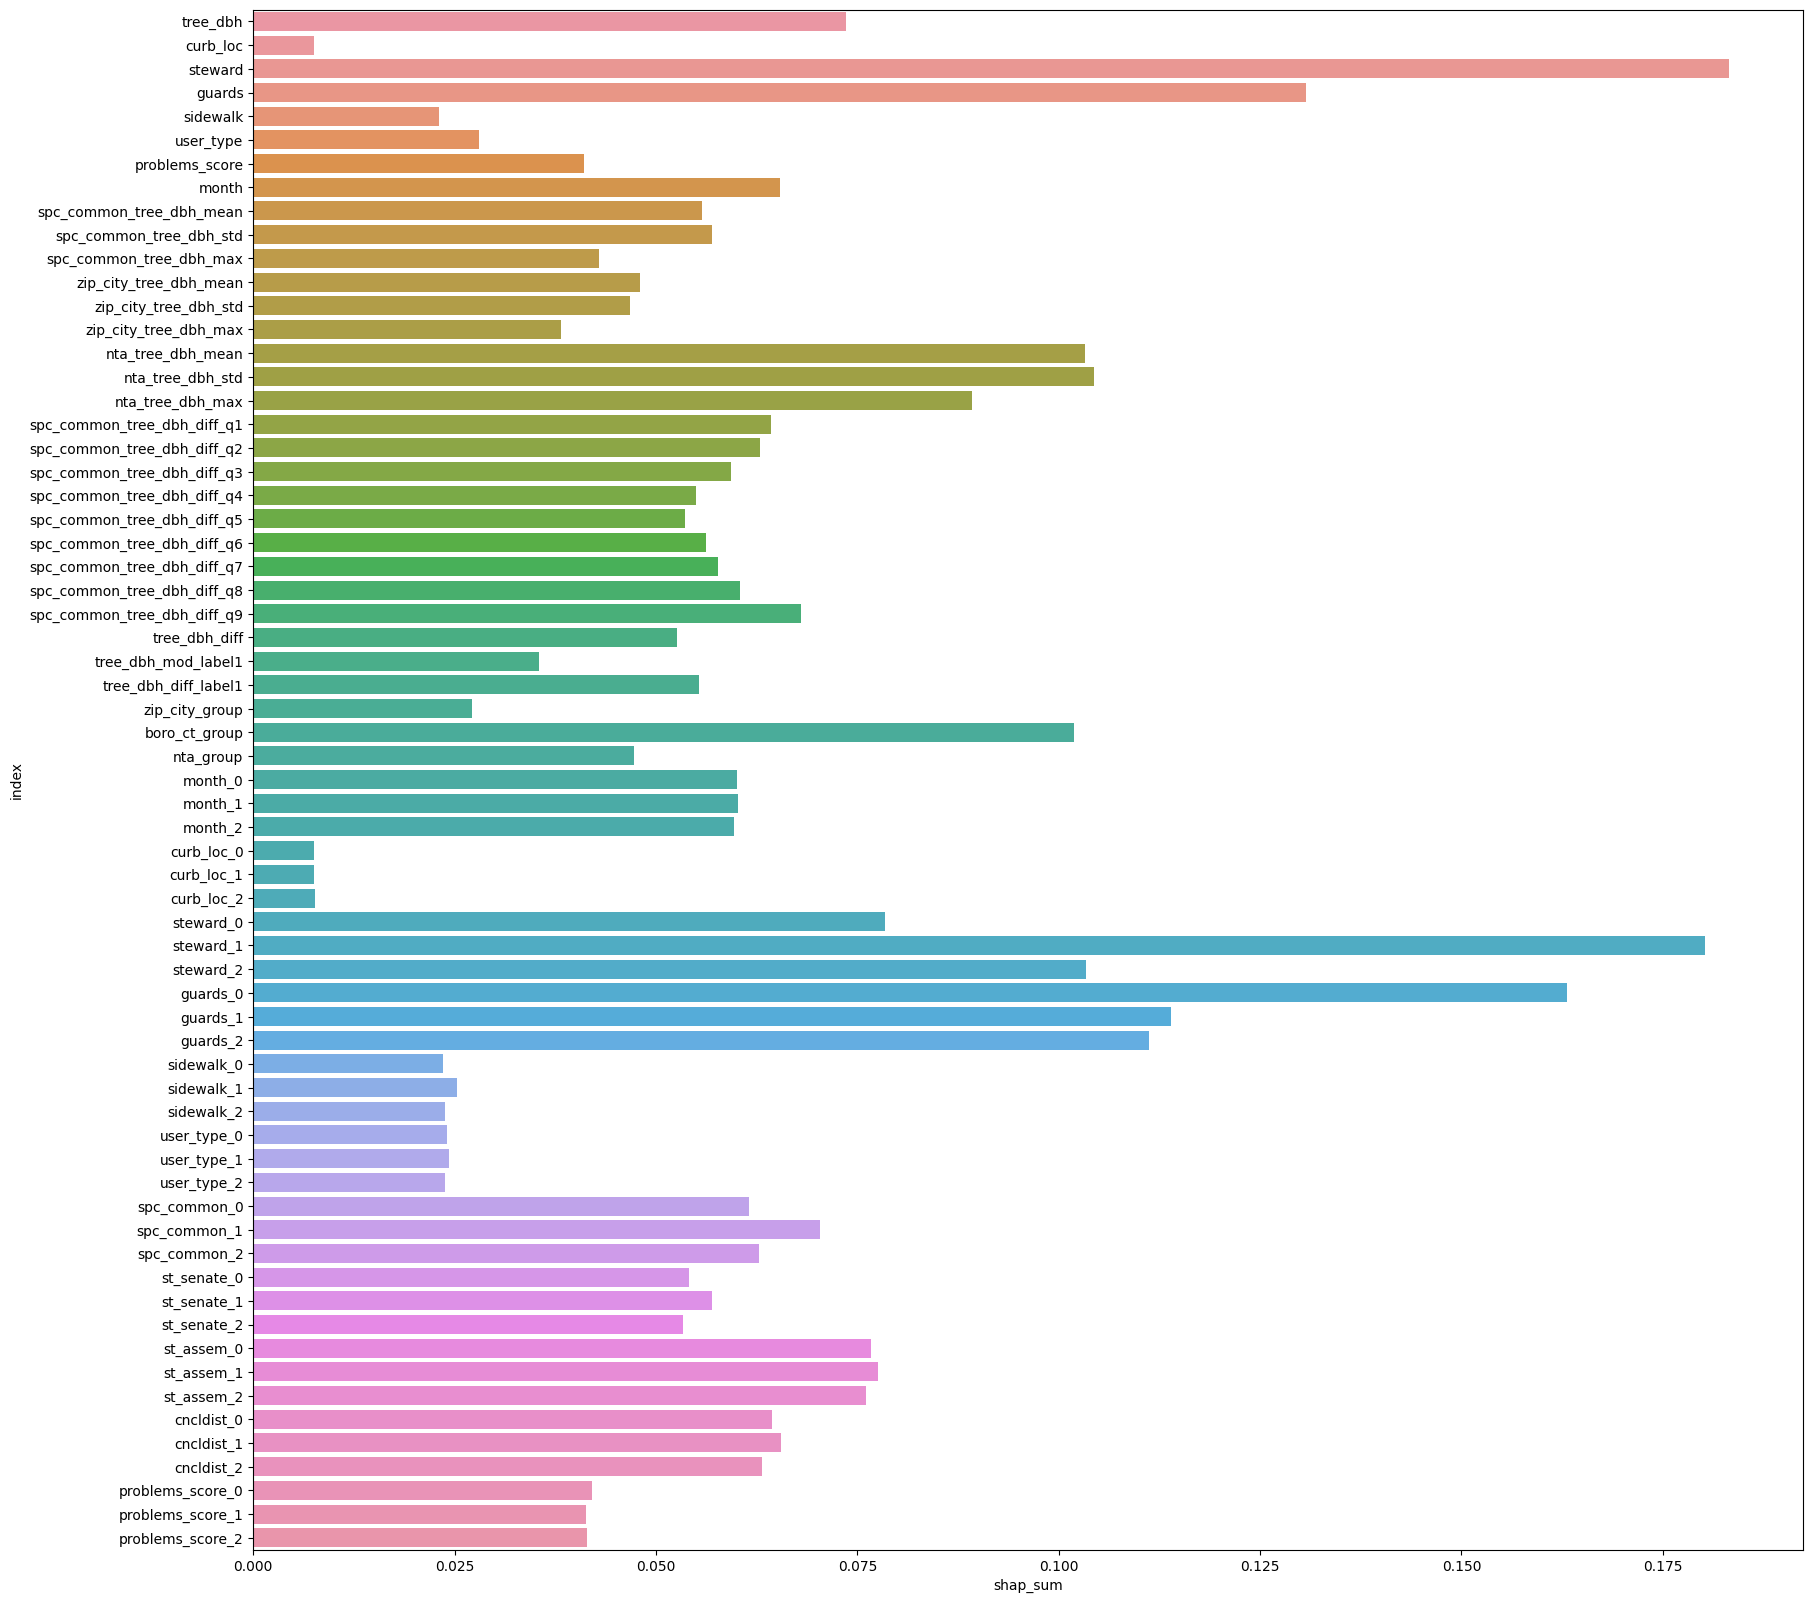

In [ ]:
feature_importance_list = []
for ml in models:
  feature = ml.feature_importances_
  feature_importance_list.append(feature)

feature_df = pd.DataFrame(np.array(feature_importance_list).T,index=usecol)
feature_df.reset_index(drop=False,inplace=True)
feature_df["shap_sum"] = feature_df.iloc[:,1:-1].sum(axis=1)
import matplotlib.pyplot as plt


fig,ax = plt.subplots(figsize=(20,20))

sns.barplot(x="shap_sum",y="index",data=feature_df)

In [ ]:
sns.barplot(y="index",data=feature_df)

TypeError: Vertical orientation requires numeric `y` variable.

In [ ]:
pd.set_option("display.max_rows",None)
display(feature_df[0].sort_values(ascending=False))

steward_2                   0.060652
tree_dbh_diff               0.046753
tree_dbh_diff_label1        0.046592
tree_dbh                    0.045871
steward_0                   0.042939
steward                     0.037500
guards                      0.032368
boro_ct_group               0.026814
nta_tree_dbh_std            0.026521
nta_tree_dbh_mean           0.025961
guards_1                    0.024573
nta_tree_dbh_max            0.022099
st_assem_0                  0.020409
st_assem_1                  0.019604
st_assem_2                  0.019580
guards_0                    0.019412
cncldist_0                  0.017635
cncldist_2                  0.017227
month                       0.017051
cncldist_1                  0.016617
month_1                     0.016295
month_2                     0.016090
month_0                     0.015918
st_senate_0                 0.014454
st_senate_1                 0.014123
st_senate_2                 0.014080
zip_city_tree_dbh_mean      0.013060
s

<Axes: xlabel='health', ylabel='problems_score'>

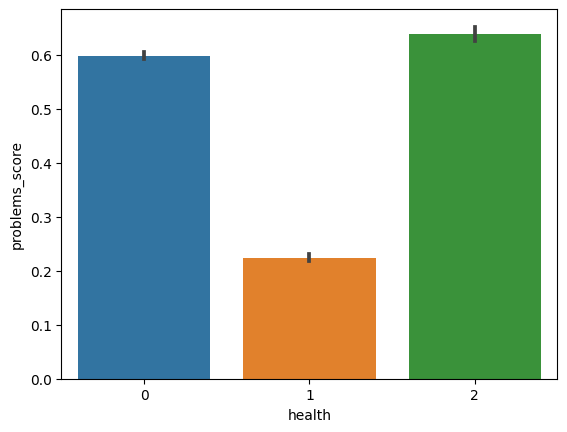

In [ ]:
sns.barplot(x="health",y="problems_score",data=train)

In [ ]:
sns.swarmplot(x="health",y="problems_score",data=train)

KeyboardInterrupt: 